In [125]:
import numpy as np
import pandas as pd
import random
from faker import Faker
from datetime import datetime, timedelta
from geopy.distance import geodesic
from scipy.stats import skewnorm, dirichlet
from mimesis import Generic
import hopsworks
import re

# Initialize Faker and set seed for reproducibility
fake = Faker()
generic = Generic('en')

np.random.seed(42)
random.seed(42)

# City coordinates and probabilities
cities = ['New York', 'London', 'Paris', 'Tokyo', 'Sydney', 'Berlin', 'Mumbai', 'São Paulo', 'Toronto', 'Dubai']
city_probs = [0.2, 0.15, 0.1, 0.1, 0.05, 0.1, 0.1, 0.05, 0.1, 0.05]
city_coords = {
    'New York': (40.7128, -74.0060), 'London': (51.5074, -0.1278), 'Paris': (48.8566, 2.3522),
    'Tokyo': (35.6762, 139.6503), 'Sydney': (-33.8688, 151.2093), 'Berlin': (52.5200, 13.4050),
    'Mumbai': (19.0760, 72.8777), 'São Paulo': (-23.5505, -46.6333), 'Toronto': (43.6532, -79.3832),
    'Dubai': (25.2048, 55.2708)
}

def generate_location(city):
    base_lat, base_lon = city_coords[city]
    if random.random() < 0.8:
        lat = base_lat + np.random.uniform(-0.1, 0.1)
        lon = base_lon + np.random.uniform(-0.1, 0.1)
    else:
        lat = base_lat + np.random.uniform(-2, 2)
        lon = base_lon + np.random.uniform(-2, 2)
    return lat, lon

def generate_users(n_users=20000):
    users = []
    interests = ['music', 'sports', 'tech', 'food', 'art', 'literature', 'cinema', 'travel', 'fitness', 'fashion']
    
    for _ in range(n_users):
        city = np.random.choice(cities, p=city_probs)
        lat, lon = generate_location(city)
        age = max(18, min(100, int(skewnorm.rvs(5, loc=25, scale=15))))
        weather_probs = dirichlet.rvs([0.3, 0.5, 0.2])[0]
        
        # Ensure at least one interest is selected
        user_interests = random.sample(interests, k=random.randint(1, min(4, len(interests))))
        
        users.append({
            'user_id': generic.person.identifier(mask='@@###@'),
            'user_lat': lat,
            'user_lon': lon,
            'user_city': city,
            'user_weather_preference': np.random.choice(['indoor', 'outdoor', 'any'], p=weather_probs),
            'age': age,
            'user_interests': ','.join(user_interests),  # Join interests into a comma-separated string
            'signup_date': fake.date_time_between(start_date='-2y', end_date='now'),
            'social_connectedness': np.random.poisson(lam=15)
        })
    return pd.DataFrame(users)


def generate_events(n_events=5000):
    events = []
    event_types = [
        'Education & Learning', 'Technology', 'Seasonal & Festivals', 'Arts & Culture', 
        'Entertainment', 'Sports & Fitness', 'Business & Networking', 'Health & Wellness', 
        'Music & Concerts', 'Food & Drink', 'Community & Causes', 'Immersive Experiences'
    ]
    weather_conditions = ['Clear', 'Rain', 'Snow', 'Cloudy', 'Windy']
    weather_probs = [0.5, 0.2, 0.05, 0.2, 0.05]
    
    current_date = datetime(2025, 3, 27, 11, 48)  # Current date and time
    
    for _ in range(n_events):
        event_type = np.random.choice(event_types)
        city = np.random.choice(cities, p=city_probs)
        lat, lon = generate_location(city)
        
        if event_type in ['Sports & Fitness', 'Seasonal & Festivals']:
            weather_condition = 'Clear' if random.random() < 0.8 else np.random.choice(['Rain', 'Cloudy'])
        elif event_type in ['Education & Learning', 'Technology', 'Business & Networking']:
            weather_condition = np.random.choice(['Clear', 'Cloudy'])
        else:
            weather_condition = np.random.choice(weather_conditions, p=weather_probs)
        
        base_temp = {
            'New York': 15, 'London': 12, 'Paris': 16, 'Tokyo': 20, 
            'Sydney': 22, 'Berlin': 14, 'Mumbai': 28, 'São Paulo': 24, 
            'Toronto': 10, 'Dubai': 32
        }[city]
        
        temp_adjustment = {
            'Clear': np.random.uniform(2, 5),
            'Rain': np.random.uniform(-3, 0),
            'Snow': np.random.uniform(-8, -3),
            'Cloudy': np.random.uniform(-1, 2),
            'Windy': np.random.uniform(-2, 1)
        }[weather_condition]
        
        temperature = round(base_temp + temp_adjustment, 1)
        
        start_time = fake.date_time_between(start_date=current_date, end_date=current_date + timedelta(days=180))
        is_weekend = start_time.weekday() >= 5
        hour_choices = [10, 14, 18] if is_weekend else [9, 13, 18, 19]
        start_time = start_time.replace(hour=np.random.choice(hour_choices))
        
        events.append({
            'event_id': generic.person.identifier(mask='@@###@'),
            'title': f"{fake.catch_phrase()} {event_type} in {city}",
            'event_type': event_type,
            'event_lat': lat,
            'event_lon': lon,
            'event_city': city,
            'start_time': start_time,
            'duration': np.random.choice([120, 180, 240, 360, 480]),
            'weather_condition': weather_condition,
            'temperature': temperature,
            'attendance_rate': np.random.beta(a=2, b=5) * 100,
            'event_indoor_capability': event_type in ['Education & Learning', 'Technology', 'Business & Networking', 
                                               'Arts & Culture', 'Entertainment', 'Immersive Experiences']
        })
    return pd.DataFrame(events)

def calculate_time_weight(interaction_time, current_time, half_life=30):
    time_diff = (current_time - interaction_time).days
    return np.exp(np.log(0.5) * time_diff / half_life)

def generate_interactions(users, events, n_interactions=100000):
    interactions = []
    interaction_types = ['maybe', 'invited & maybe', 'no', 'yes', 'invited & yes', 'invited & no', 'invited']
    attempts = n_interactions * 5
    current_time = datetime(2025, 3, 27, 11, 48)
    
    # Create a user participation bias - some users are much more active than others
    # Using a reversed power law distribution to favor higher event attendance
    participation_factor = 1 - np.random.power(0.5, size=len(users))
    users['participation_factor'] = participation_factor
    
    # Sort users by participation factor (higher values first)
    users = users.sort_values('participation_factor', ascending=False)
    
    # Group events by city to increase the probability of users attending events in their city
    events_by_city = {city: events[events['event_city'] == city] for city in cities}
    
    # Create a dictionary to track user event counts
    user_event_count = {user_id: 0 for user_id in users['user_id']}
    
    for _ in range(attempts):
        if len(interactions) >= n_interactions:
            break
            
        # Sample users with probability proportional to their participation factor
        # This ensures users with higher participation factors get selected more often
        user_probs = users['participation_factor'] / users['participation_factor'].sum()
        user_idx = np.random.choice(range(len(users)), p=user_probs)
        user = users.iloc[user_idx]
        
        # Prioritize events in the user's city with higher probability
        user_city_events = events_by_city.get(user['user_city'], pd.DataFrame())
        if len(user_city_events) > 0 and random.random() < 0.85:
            event = user_city_events.sample(1).iloc[0]
        else:
            event = events.sample(1).iloc[0]
        
        distance = geodesic((user['user_lat'], user['user_lon']), 
                           (event['event_lat'], event['event_lon'])).km
        
        # Adjust distance calculation to favor closer events
        distance_score = np.exp(-distance/50)  # More forgiving distance score (changed from 10 to 50)
        
        weather_score = 1.5 if (event['weather_condition'] == 'Clear' and 
                               user['user_weather_preference'] in ['outdoor', 'any']) else 0.8
        
        # Increase the impact of social connectedness
        social_score = np.log1p(user['social_connectedness']) / 5  # Changed from 10 to 5
        
        # Add participation factor to interaction probability
        participation_boost = user['participation_factor'] * 0.5
        
        # Combine all factors with emphasis on participation
        interaction_prob = 0.5*distance_score + 0.1*weather_score + 0.1*social_score + 0.3*participation_boost
        
        # Increase the maximum distance threshold
        max_distance = 100 if random.random() < 0.8 else 500  # Increased from 50/300 to 100/500
        
        if distance < max_distance and (random.random() < interaction_prob):
            interaction_time = fake.date_time_between(
                start_date=event['start_time'] - timedelta(days=30), 
                end_date=event['start_time']
            )
            time_weight = calculate_time_weight(interaction_time, current_time)
            interaction_prob *= time_weight
            
            # Adjust interaction type probabilities to favor positive responses
            if distance <= 10:
                interaction_type_probs = [0.15, 0.25, 0.05, 0.35, 0.15, 0.03, 0.02]  # More yes and invited & yes
            elif distance <= 40:
                interaction_type_probs = [0.20, 0.20, 0.05, 0.30, 0.15, 0.05, 0.05]
            elif distance <= 100:
                interaction_type_probs = [0.25, 0.15, 0.10, 0.20, 0.15, 0.10, 0.05]
            elif distance <= 200:
                interaction_type_probs = [0.20, 0.10, 0.15, 0.15, 0.15, 0.15, 0.10]
            else:
                interaction_type_probs = [0.15, 0.10, 0.20, 0.15, 0.10, 0.20, 0.10]
            
            # Select interaction type
            interaction_type = np.random.choice(interaction_types, p=interaction_type_probs)
            
            # Determine if this counts as attendance (maybe or yes)
            is_attending = interaction_type in ['maybe', 'invited & maybe', 'yes', 'invited & yes']
            
            # Add to user's event count if attending
            if is_attending:
                user_event_count[user['user_id']] += 1
                
            # Create the interaction record
            interactions.append({
                'interaction_id': generic.person.identifier(mask='@@###@'),
                'user_id': user['user_id'],
                'event_id': event['event_id'],
                'interaction_type': interaction_type,
                'distance_to_event': distance,
                'interaction_label': 1 if is_attending else 0
            })
    
    # Convert to DataFrame
    interactions_df = pd.DataFrame(interactions)
    
    return interactions_df

# Generate data
users_df = generate_users(n_users=20000)
events_df = generate_events(n_events=5000)
interactions_df = generate_interactions(users_df, events_df, n_interactions=100000)

# Calculate and display the distribution of events attended per user
attendance_counts = interactions_df[interactions_df['interaction_label'] == 1].groupby('user_id').size()
attendance_distribution = attendance_counts.value_counts().sort_index()

print("Distribution of events attended per user:")
for count, num_users in attendance_distribution.items():
    print(f"{num_users} attended {count} events")

# # Optional: Save data to CSV files
# users_df.to_csv('users.csv', index=False)
# events_df.to_csv('events.csv', index=False)
# interactions_df.to_csv('interactions.csv', index=False)

Distribution of events attended per user:
2262 attended 1 events
1788 attended 2 events
1690 attended 3 events
1811 attended 4 events
1781 attended 5 events
1702 attended 6 events
1514 attended 7 events
1257 attended 8 events
946 attended 9 events
678 attended 10 events
453 attended 11 events
268 attended 12 events
158 attended 13 events
80 attended 14 events
41 attended 15 events
21 attended 16 events
7 attended 17 events
3 attended 18 events
4 attended 19 events
2 attended 20 events


In [126]:
merged_df = users_df.merge(interactions_df, on="user_id",how="inner")\
    .merge(events_df,on="event_id",how="inner")

print(len(merged_df))
merged_df.head()


100052


,user_id,user_lat,user_lon,user_city,user_weather_preference,age,user_interests,signup_date,social_connectedness,participation_factor,...,event_type,event_lat,event_lon,event_city,start_time,duration,weather_condition,temperature,attendance_rate,event_indoor_capability
0,QO416Y,48.946743,2.398599,Paris,outdoor,40,art,2024-06-21 23:27:16.192918,11,0.997628,...,Arts & Culture,48.87365,2.434839,Paris,2025-07-26 18:10:27.139970,120,Cloudy,17.5,27.502523,True
1,EC679A,48.902004,2.390784,Paris,indoor,45,literature,2024-12-10 11:17:02.827973,16,0.991587,...,Arts & Culture,48.87365,2.434839,Paris,2025-07-26 18:10:27.139970,120,Cloudy,17.5,27.502523,True
2,HW266J,48.902408,2.300683,Paris,indoor,39,"literature,travel,fitness",2023-08-21 04:52:15.333684,11,0.999903,...,Arts & Culture,48.87365,2.434839,Paris,2025-07-26 18:10:27.139970,120,Cloudy,17.5,27.502523,True
3,AB481B,48.946070,2.316190,Paris,outdoor,35,"fashion,literature,art",2023-05-30 21:23:51.883854,21,0.998048,...,Arts & Culture,48.87365,2.434839,Paris,2025-07-26 18:10:27.139970,120,Cloudy,17.5,27.502523,True
4,CB345R,48.939505,2.424839,Paris,indoor,45,"music,travel",2024-12-18 17:48:55.231105,11,0.946594,...,Arts & Culture,48.87365,2.434839,Paris,2025-07-26 18:10:27.139970,120,Cloudy,17.5,27.502523,True


In [127]:
merged_df = pd.read_csv("/home/nkama/masters_thesis_project/thesis/sythesize_from_scratch/test_merged_data.csv")
merged_df.columns

Index(['Unnamed: 0', 'user_id', 'gender', 'user_lat', 'user_lon', 'user_city',
       'indoor_outdoor_preference', 'age', 'user_interests', 'signup_date',
       'interaction_id', 'event_id', 'interaction_type', 'distance_to_event',
       'interaction_label', 'interest_match', 'title', 'event_category',
       'event_lat', 'event_lon', 'event_city', 'start_time', 'duration',
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability'],
      dtype='object')

In [ ]:
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
#CANDIDATE_FEATURES = ["event_id","event_type", "event_city"]
CANDIDATE_FEATURES = ["event_id", "title","event_category", "event_city"]

## <span style="color:#ff5f27">🧬 Train Retrieval Model </span>



## <span style="color:#ff5f27">📝 Imports </span>


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import StringLookup, Normalization
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import hopsworks
import warnings
import re
warnings.filterwarnings('ignore')

2025-04-27 17:53:41.359146: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 17:53:41.429746: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 17:53:41.733431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-27 17:53:41.733503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-27 17:53:41.796854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## <span style="color:#ff5f27">🔮 Connect to Hopsworks Feature Store </span>

In [124]:

# Connect to Hopsworks Feature Store
project = hopsworks.login()
fs = project.get_feature_store()



2025-05-01 20:18:14,203 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-01 20:18:14,550 INFO: Initializing external client
2025-05-01 20:18:14,551 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-05-01 20:18:16,196 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788


---

## <span style="color:#ff5f27">🔪 Feature Selection </span>


In [3]:
import tensorflow as tf
import pandas as pd

# Load from Hopsworks feature groups
users_fg = fs.get_feature_group(name="users", version=1)
events_fg = fs.get_feature_group(name="events", version=1)
interactions_fg = fs.get_feature_group(name="interactions", version=1)


In [4]:

# Define features for query and candidate towers (retrieval model only)
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
#CANDIDATE_FEATURES = ["event_id","event_type", "event_city"]
CANDIDATE_FEATURES = ["event_id", "title","event_type", "event_city"]

In [6]:

# Join user + event features with interactions
selected_features = interactions_fg.select(["interaction_id"])\
    .join(users_fg.select(QUERY_FEATURES), on="user_id")\
    .join(events_fg.select(CANDIDATE_FEATURES), on="event_id")


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [ ]:

# Create feature view
feature_view = fs.create_feature_view(
    name='event_retrieval',
    version=1,
    query=selected_features,
)


## <span style="color:#ff5f27">🏋️ Training Dataset </span>


In [5]:
feature_view = fs.get_feature_view(
    name='event_retrieval',
    version=1,
)

In [6]:
# Split dataset
train_df, val_df, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1, 
    test_size=0.01,
    description='Event retrieval dataset splits',
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (12.32s) 


In [29]:
train_df.head()

,interaction_id,user_id,user_city,age,user_interests,event_id,title,event_type,event_city
0,4140ef03-afce-4fe5-a9a9-8e43fd45dfaa,LT819S,Sydney,26,sports literature cinema,OI841N,reengineered 3rdgeneration array food drink in...,Food & Drink,Tokyo
1,BI623H,UP287J,Mumbai,56,tech food travel,IO571I,balanced interactive artificial intelligence t...,Technology,Mumbai
2,08e342ae-f9b5-4358-9f41-cf89671b9ae2,RG723K,Mumbai,32,literature music,YW813D,visionary optimal monitoring education learnin...,Education & Learning,Paris
3,7cfbb86b-6d7a-4f1a-b05f-ffa78bc41ffb,DM205I,Toronto,40,food sports cinema,RM794Y,reduced 6thgeneration complexity immersive exp...,Immersive Experiences,Paris
4,NQ623P,UE711E,Mumbai,23,music art,UK320K,polarized uniform superstructure technology in...,Technology,Mumbai


In [53]:

CO980H = list(test_df[test_df["user_id"]=="OL763P"]["event_id"])
CO980H

['CJ748F']

In [ ]:
# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
user_interest_list = train_df["user_interests"].unique().tolist()
title_list = train_df["title"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


✅ Training set size: 147551
📌 Unique Users: 24972, Events: 15393


## <span style="color:#ff5f27">🏰 Two Tower Model </span>


In [54]:
# Improved Two-Tower Model with Enhanced Regularization
import tensorflow as tf
import tensorflow_recommenders as tfrs
from typing import Dict
import numpy as np

# Prepare vocabulary lists for Lookup & Embedding layers
user_id_list = train_df["user_id"].unique().tolist()
event_id_list = train_df["event_id"].unique().tolist()
user_city_list = train_df["user_city"].unique().tolist()
event_city_list = train_df["event_city"].unique().tolist()
event_type_list = train_df["event_type"].unique().tolist()
user_interest_list = train_df["user_interests"].unique().tolist()
title_list = train_df["title"].unique().tolist()

# Print summary
print(f"✅ Training set size: {len(train_df)}")
print(f"📌 Unique Users: {len(user_id_list)}, Events: {len(event_id_list)}")


# Reduced embedding dimension
EMBED_DIM = 32  # Reduced from 64
BATCH_SIZE = 1024
L2_REG = 0.01  # Increased L2 regularization (10x stronger)
DROPOUT_RATE = 0.5  # Increased dropout rate

# Define features for query and candidate towers
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "event_city", "event_type", "title"]

# Build tf.data.Dataset with proper tensor shapes
def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices({
        col: tf.constant(df[col].values) for col in df.columns
    })

# Create datasets with proper batching and shuffling
train_ds = df_to_ds(train_df).batch(BATCH_SIZE).cache().shuffle(BATCH_SIZE * 10)
val_ds = df_to_ds(val_df).batch(BATCH_SIZE).cache()

# Create item dataset with proper tensor shapes
item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
item_ds = tf.data.Dataset.from_tensor_slices({
    col: tf.constant(item_df[col].astype(str).values) for col in CANDIDATE_FEATURES
})

# Query Tower with improved regularization
class QueryTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # User ID embedding with stronger L2 regularization
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)  # Max-norm constraint
            )
        ])

        # Age normalization with batch norm
        self.normalized_age = tf.keras.layers.Normalization(axis=None)
        
        # City embedding with regularization
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=user_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(user_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Text processing with int mode and reduced complexity
        self.interest_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=100,
            output_mode='multi_hot'
        )

        self.interest_embedding = tf.keras.layers.Embedding(
            input_dim=101,  # max_tokens + 1 for OOV
            output_dim=self.emb_dim//2,  # Reduced dimension
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),  # Added activity regularization
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text features
        interests_encoded = self.interest_vectorizer(inputs["user_interests"])
        interests_embedding = self.interest_embedding(interests_encoded)
        pooled_interests = tf.reduce_mean(interests_embedding, axis=1)
        
        # Process city with embedding instead of one-hot
        city_emb = self.city_embedding(inputs["user_city"])
        
        # Add Gaussian noise during training for better generalization
        age_normalized = self.normalized_age(inputs["age"])
        if training:
            age_normalized = age_normalized + tf.random.normal(
                tf.shape(age_normalized), mean=0.0, stddev=0.1
            )
        
        # Concatenate features
        combined = tf.concat([
            self.user_embedding(inputs["user_id"]),
            tf.reshape(age_normalized, (-1, 1)),
            city_emb,
            pooled_interests
        ], axis=1)

        return self.fnn(combined)
    def get_config(self):
        config = super().get_config()
        config.update({
            "emb_dim": self.emb_dim,
        })
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)
# Item Tower with improved regularization
class ItemTower(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.emb_dim = EMBED_DIM

        # Event ID embedding with stronger L2 regularization
        self.event_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_id_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_id_list) + 1, 
                self.emb_dim,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Type and city embeddings with regularization
        self.type_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_type_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_type_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])
        
        self.city_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=event_city_list, mask_token=None),
            tf.keras.layers.Embedding(
                len(event_city_list) + 1, 
                self.emb_dim//2,
                embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
                embeddings_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

        # Simplified title processing
        self.title_vectorizer = tf.keras.layers.TextVectorization(
            max_tokens=500,  # Reduced from 1000
            output_mode='int',
            output_sequence_length=10  # Reduced from 20
        )
        self.title_embedding = tf.keras.layers.Embedding(
            input_dim=501, 
            output_dim=32,  # Reduced from 64
            embeddings_regularizer=tf.keras.regularizers.l2(L2_REG),
            embeddings_constraint=tf.keras.constraints.MaxNorm(3)
        )
        self.title_pool = tf.keras.layers.GlobalAveragePooling1D()  # Simpler pooling

        # Simplified network with stronger regularization
        self.fnn = tf.keras.Sequential([
            tf.keras.layers.Dense(
                128,  # Reduced from 256
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.Dense(
                self.emb_dim,
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG),
                activity_regularizer=tf.keras.regularizers.l1(1e-5),
                kernel_constraint=tf.keras.constraints.MaxNorm(3)
            )
        ])

    def call(self, inputs: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Process text with simpler approach
        title_encoded = self.title_vectorizer(inputs["title"])
        title_embedding = self.title_embedding(title_encoded)
        pooled_title = self.title_pool(title_embedding)
        
        # Process categorical features with embeddings
        type_emb = self.type_embedding(inputs["event_type"])
        city_emb = self.city_embedding(inputs["event_city"])
        
        # Concatenate features
        combined = tf.concat([
            self.event_embedding(inputs["event_id"]),
            type_emb,
            city_emb,
            pooled_title
        ], axis=1)

        return self.fnn(combined)
    def get_config(self):
        config = super().get_config()
        config.update({
            "emb_dim": self.emb_dim,
        })
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)
# Initialize models
query_model = QueryTower()
item_model = ItemTower()

# Adapt layers to training data
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)
item_model.title_vectorizer.adapt(item_df["title"].values)

# Initialize models with sample data
query_sample = next(iter(df_to_ds(train_df[QUERY_FEATURES]).batch(1)))
item_sample = next(iter(df_to_ds(item_df[CANDIDATE_FEATURES]).batch(1)))
_ = query_model(query_sample)
_ = item_model(item_sample)

# Fixed Two-Tower Model with proper candidate handling
class TwoTowerModel(tfrs.models.Model):
    def __init__(self, query_model, item_model):
        super().__init__()
        self.query_model = query_model
        self.item_model = item_model
        
        # Temperature parameter for scaling similarity scores
        self.temperature = tf.Variable(0.2, trainable=True)  # Increased from 0.1
        
        # Create candidates dataset with proper batching and mapping
        candidates = item_ds.batch(BATCH_SIZE).map(lambda x: self.item_model(x))
        
        # Set up retrieval task with factorized top-k
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=candidates
            ),
            temperature=self.temperature
        )
    def call(self, inputs):
        query_embeddings = self.query_model(inputs)
        item_embeddings = self.item_model(inputs)
        return query_embeddings, item_embeddings
    
    def compute_loss(self, features, training=False):
        # Get query and candidate embeddings
        query_embeddings = self.query_model(features, training=training)
        candidate_embeddings = self.item_model(features, training=training)
        
        # Return task loss
        return self.task(query_embeddings, candidate_embeddings)
    def get_config(self):
        config = super().get_config()
        config.update({
            "emb_dim": self.emb_dim,
        })
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)
# Create and compile model with optimized learning rate
model = TwoTowerModel(query_model, item_model)

# Optimizer with learning rate schedule and weight decay
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5e-4,  # Reduced from 1e-3
        decay_steps=10000
    ),
    weight_decay=0.01,  # Increased from 0.004
    clipnorm=1.0
)

model.compile(optimizer=optimizer)

# Train with early stopping and learning rate reduction
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Increased max epochs
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            patience=100,  # Increased patience
            restore_best_weights=True,
            min_delta=0.001  # Minimum improvement required
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_factorized_top_k/top_100_categorical_accuracy',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
        
    ]
)

# Evaluate final performance
eval_results = model.evaluate(
    val_ds,
    return_dict=True
)
print("\nFinal Evaluation Metrics:")
for metric, value in eval_results.items():
    print(f"{metric}: {value:.4f}")




✅ Training set size: 147551
📌 Unique Users: 24972, Events: 15393
Epoch 1/10
145/145 [==============================] - 53s 332ms/step - factorized_top_k/top_1_categorical_accuracy: 0.2156 - factorized_top_k/top_5_categorical_accuracy: 0.2917 - factorized_top_k/top_10_categorical_accuracy: 0.3407 - factorized_top_k/top_50_categorical_accuracy: 0.4399 - factorized_top_k/top_100_categorical_accuracy: 0.4613 - loss: 13934.4604 - regularization_loss: 7.6512 - total_loss: 13942.1116 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_10_categorical_accuracy: 6.0321e-05 - val_factorized_top_k/top_50_categorical_accuracy: 0.6278 - val_factorized_top_k/top_100_categorical_accuracy: 0.6284 - val_loss: 1021.9645 - val_regularization_loss: 5.7630 - val_total_loss: 1027.7274 - lr: 4.9974e-04
Epoch 2/10
145/145 [==============================] - 40s 275ms/step - factorized_top_k/top_1_categorical_accur

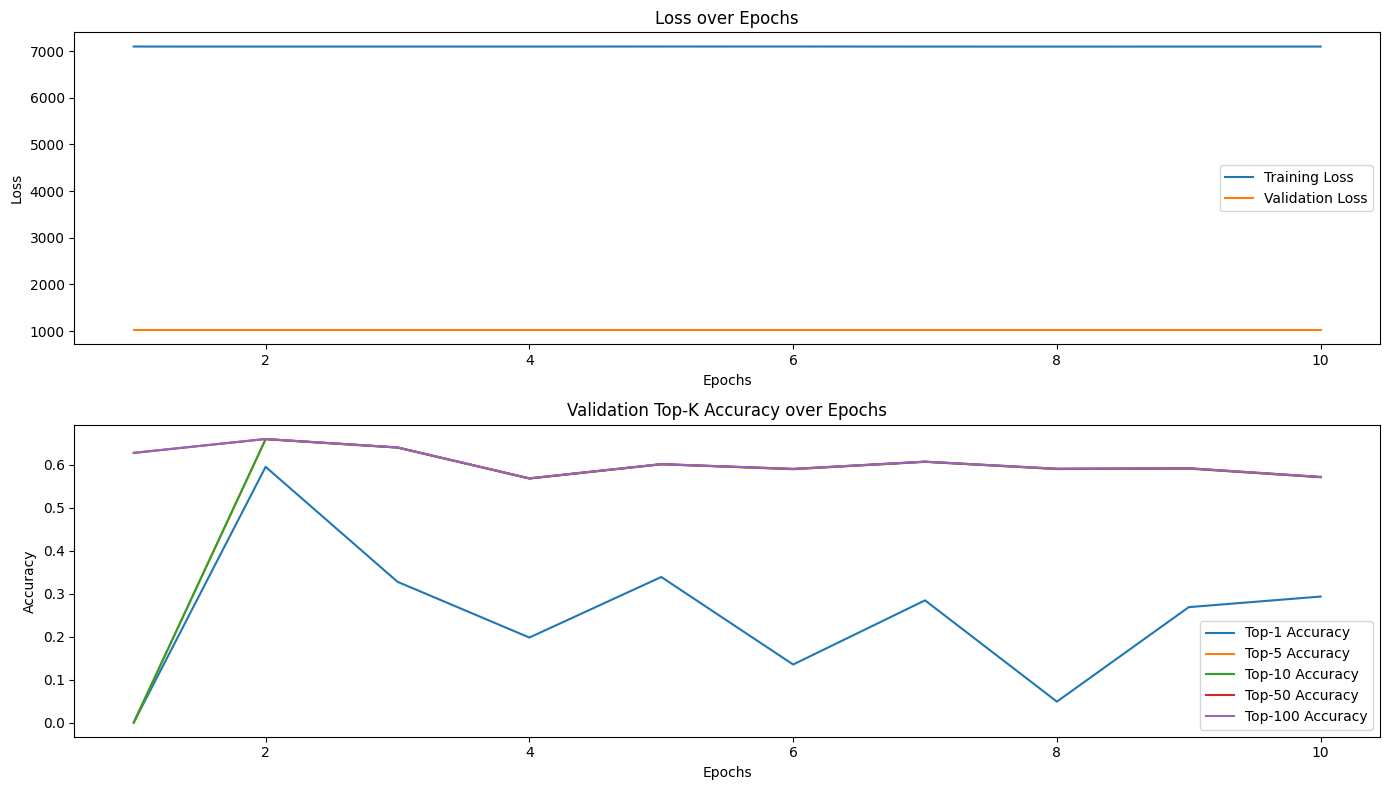

In [55]:
import matplotlib.pyplot as plt


# Plotting function
def plot_metrics(history):
    epochs = range(1, len(history["loss"]) + 1)

    plt.figure(figsize=(14, 8))

    # Plot Loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, history["loss"], label="Training Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Top-K Accuracies
    plt.subplot(2, 1, 2)
    for k in [1, 5, 10, 50, 100]:
        metric = f"val_factorized_top_k/top_{k}_categorical_accuracy"
        plt.plot(epochs, history[metric], label=f"Top-{k} Accuracy")

    plt.title("Validation Top-K Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot
#plot_metrics(history)
plot_metrics(model_history.history)


In [63]:
import tensorflow as tf
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
query_model = model.query_model
candidate_model = model.item_model
# --- 1. Precompute item (candidate) embeddings ---
CANDIDATE_FEATURES = ["event_id", "event_type", "event_city", "title"]

def precompute_item_embeddings(item_model, item_df, batch_size=1024):
    item_features = {
        "event_id": item_df["event_id"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values,
        "title": item_df["title"].values
    }
    ds = tf.data.Dataset.from_tensor_slices(item_features).batch(batch_size)
    embeddings = []
    for batch in ds:
        emb = item_model(batch).numpy()
        embeddings.append(emb)
    item_embeddings = np.vstack(embeddings)
    return item_embeddings

# --- 2. Build Faiss index (cosine similarity via normalized dot product) ---
def build_faiss_index(item_embeddings):
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

# --- 3. Evaluate Recall@K on test set ---
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
K_VALUES = [1, 5, 10, 50, 100]

def get_user_embedding(query_model, user_row):
    user_features = {
        "user_id": np.array([user_row["user_id"]]),
        "user_city": np.array([user_row["user_city"]]),
        "age": np.array([user_row["age"]], dtype=np.float32),
        "user_interests": np.array([user_row["user_interests"]])
    }
    emb = query_model(user_features).numpy()
    faiss.normalize_L2(emb)
    return emb

def evaluate_model(query_model, test_df, faiss_index, item_embeddings, item_ids, k_values=K_VALUES):
    hits_at_k = {k: 0 for k in k_values}
    total = 0
    all_scores = []
    all_labels = []
    for idx, row in test_df.iterrows():
        user_emb = get_user_embedding(query_model, row)
        D, I = faiss_index.search(user_emb, max(k_values))
        recommended_ids = [item_ids[i] for i in I[0]]
        true_event_id = row["event_id"]
        for k in k_values:
            if true_event_id in recommended_ids[:k]:
                hits_at_k[k] += 1
        # For PR/ROC: positive and negatives
        actual_item_idx = item_ids.index(true_event_id) if true_event_id in item_ids else -1
        if actual_item_idx >= 0:
            actual_item_embedding = item_embeddings[actual_item_idx]
            actual_score = np.dot(user_emb[0], actual_item_embedding)
            all_scores.append(actual_score)
            all_labels.append(1)
            neg_indices = np.random.choice(
                [i for i in range(len(item_embeddings)) if i != actual_item_idx],
                size=min(9, len(item_embeddings)-1),
                replace=False
            )
            for neg_idx in neg_indices:
                neg_score = np.dot(user_emb[0], item_embeddings[neg_idx])
                all_scores.append(neg_score)
                all_labels.append(0)
        total += 1
    recall_at_k = {k: hits_at_k[k] / total for k in k_values}
    return recall_at_k, np.array(all_scores), np.array(all_labels)

def plot_evaluation_metrics(recall_at_k, all_scores, all_labels):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    ax1.plot(list(recall_at_k.keys()), list(recall_at_k.values()), marker='o')
    ax1.set_title('Recall@K')
    ax1.set_xlabel('K')
    ax1.set_ylabel('Recall')
    ax1.grid(True)
    precision, recall, _ = precision_recall_curve(all_labels, all_scores)
    ap = average_precision_score(all_labels, all_scores)
    ax2.plot(recall, precision, label=f'AP = {ap:.3f}')
    ax2.set_title('Precision-Recall Curve')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    ax2.grid(True)
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    ax3.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_title('ROC Curve')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend()
    ax3.grid(True)
    plt.tight_layout()
    plt.savefig('model_evaluation_metrics.png')
    plt.show()
    return fig


In [64]:
item_model = model.item_model
query_model = model.query_model

# Adapt layers to training data
query_model.normalized_age.adapt(train_df["age"].values)
query_model.interest_vectorizer.adapt(train_df["user_interests"].values)
item_model.title_vectorizer.adapt(item_df["title"].values)

# Initialize models with sample data
query_sample = next(iter(df_to_ds(train_df[QUERY_FEATURES]).batch(1)))
item_sample = next(iter(df_to_ds(item_df[CANDIDATE_FEATURES]).batch(1)))
print(model.query_model(query_sample))
model.item_model(item_sample)



tf.Tensor(
[[ 0.04123179 -0.24592896 -0.11084525 -0.24655697 -0.15718123 -0.10350272
   0.17139858 -0.10052232 -0.04877723  0.10672387  0.0332548  -0.06516412
   0.18375288  0.29140913 -0.09106125 -0.287091   -0.21621928  0.07265562
   0.18934621 -0.18101446  0.03771805  0.01892124  0.03179292  0.15838522
   0.10314888 -0.08664712 -0.03287879 -0.13360088  0.02875555  0.0866585
  -0.07787332  0.10579105]], shape=(1, 32), dtype=float32)


<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[-1.7040239e-03,  1.5364005e-03,  3.3223917e-04,  4.1901495e-04,
        -1.7779414e-05, -2.9339707e-03,  4.8920652e-03, -1.3322989e-03,
         3.5709189e-04,  4.1283434e-04, -1.7822227e-03, -2.3680727e-03,
        -1.1942810e-03,  1.1223906e-03,  1.1736527e-04,  1.3008215e-03,
         2.5440771e-03,  2.3732129e-03, -1.1281306e-03,  1.5716983e-03,
        -1.7257640e-03,  3.9471705e-03, -1.2728665e-04, -3.0286850e-03,
        -7.3894748e-04,  6.4996071e-04, -9.9194515e-04,  6.6149677e-04,
         2.3422626e-04,  6.2709022e-04, -1.9476411e-03, -3.8141105e-04]],
      dtype=float32)>

Found 15393 unique items for evaluation
Precomputing item embeddings...
Building Faiss index...
Evaluating model...

Model Evaluation Results:
Recall@1: 0.0048
Recall@5: 0.0108
Recall@10: 0.0139
Recall@50: 0.1627
Recall@100: 0.4135
Average Precision: 0.1000
ROC AUC: 0.5000


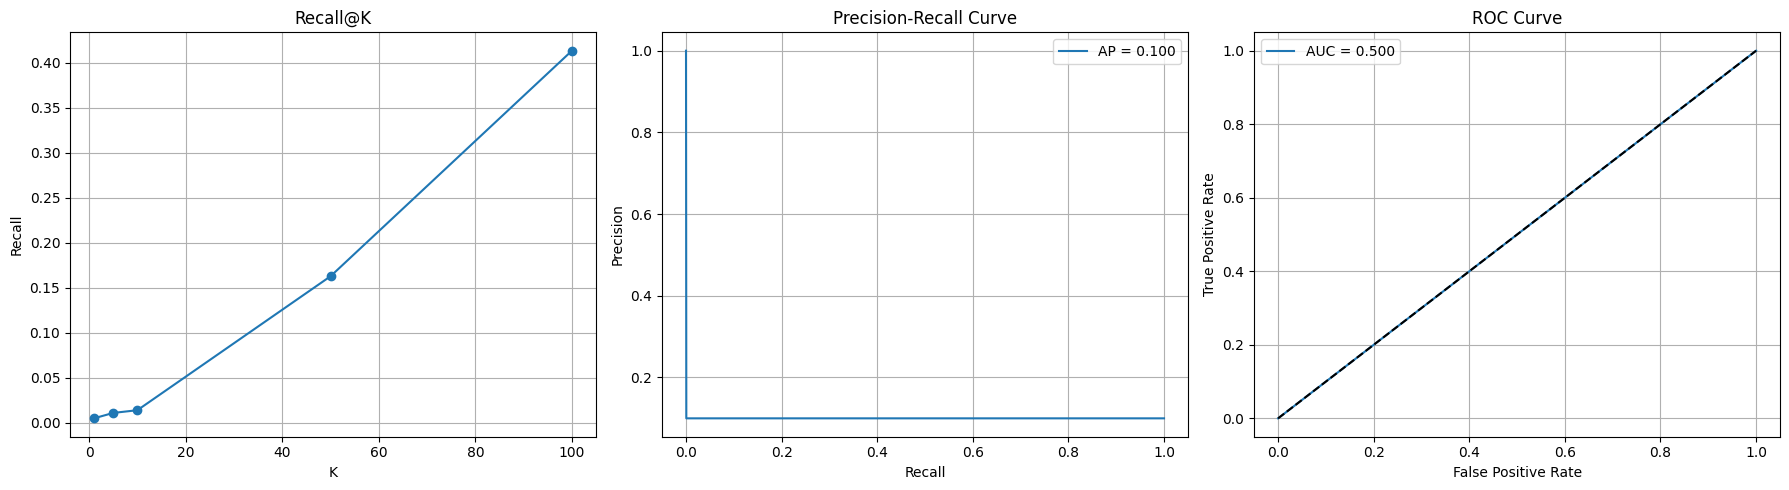


Sample Recommendations:
User: EA476J
User Interests: travel
user not in sequence
Actual Interaction: IU296X
Top 5 Recommendations: ['XT330P', 'QE192N', 'QP798C', 'JJ132P', 'KH489A', 'PB538F', 'ZO141K', 'DH521K', 'UK320K', 'RM794Y']


In [69]:

def main():
    # Assume you have train_df, val_df, test_df, query_model, candidate_model already in memory
    # Prepare unique item DataFrame
    item_df = train_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    item_ids = item_df["event_id"].tolist()
    print(f"Found {len(item_df)} unique items for evaluation")
    # Precompute item embeddings
    print("Precomputing item embeddings...")
    item_embeddings = precompute_item_embeddings(item_model, item_df)
    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings)
    # Evaluate model
    print("Evaluating model...")
    recall_at_k, all_scores, all_labels = evaluate_model(
        query_model, test_df, faiss_index, item_embeddings, item_ids
    )
    print("\nModel Evaluation Results:")
    for k, recall in recall_at_k.items():
        print(f"Recall@{k}: {recall:.4f}")
    ap = average_precision_score(all_labels, all_scores)
    print(f"Average Precision: {ap:.4f}")
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
    plot_evaluation_metrics(recall_at_k, all_scores, all_labels)
    # Sample recommendations
    print("\nSample Recommendations:")
    sample_user = test_df.iloc[10]
    user_emb = get_user_embedding(query_model, sample_user)
    D, I = faiss_index.search(user_emb, 10)
    recommendations = [item_ids[i] for i in I[0]]
    print(f"User: {sample_user['user_id']}")
    print(f"User Interests: {sample_user['user_interests']}")
    if sample_user['event_id'] in recommendations:
        print("User in sequence - Position:", recommendations.index(sample_user['event_id']) + 1)
    else:
        print("user not in sequence")
    print(f"Actual Interaction: {sample_user['event_id']}")
    print(f"Top 5 Recommendations: {recommendations}")
    return recall_at_k, all_scores, all_labels

if __name__ == "__main__":
    main()


In [66]:
print("\nSample Recommendations:")
sample_user = test_df.iloc[10]
user_emb = get_user_embedding(query_model, sample_user)
D, I = faiss_index.search(user_emb, 50)
recommendations = [item_ids[i] for i in I[0]]
print(f"User: {sample_user['user_id']}")
print(f"User Interests: {sample_user['user_interests']}")
if sample_user['event_id'] in recommendations:
    print("User in sequence - Position:", recommendations.index(sample_user['event_id']) + 1)
else:
    print("user not in sequence")
print(f"Actual Interaction: {sample_user['event_id']}")
print(f"Top 5 Recommendations: {recommendations}")



Sample Recommendations:


NameError: name 'faiss_index' is not defined

# <span style="color:#ff5f27">Building Ranking Model </span>

In [60]:
import pandas as pd
#from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, precision_recall_fscore_support
import joblib
import hopsworks

In [71]:
weather_rank_fg = fs.get_feature_group(
    name="weather_ranking",
    version=1
)

no_weather_rank_fg = fs.get_feature_group(
    name="no_weather_ranking",
    version=1
)


## <span style="color:#ff5f27">⚙️ Feature View Creation </span>


In [ ]:
# Select features
selected_features_customers = users_fg.select_all()

fs.get_or_create_feature_view( 
    name='users',
    query=selected_features_customers,
    version=1,
)
# Select features
selected_features_articles = events_fg.select_all()

fs.get_or_create_feature_view(
    name='events',
    query=selected_features_articles,
    version=1,
)


In [79]:
NO_WEATHER_SELECTED_FEATURES =['interaction_distance_to_event',
       'event_type','event_city', 'duration',
       'attendance_rate', 'event_indoor_capability', 'user_city',
       'age','user_interests','label']

WEATHER_SELECTED_FEATURES =['interaction_distance_to_event',
       'event_type','event_city', 'duration','weather_condition', 'temperature',
       'attendance_rate', 'event_indoor_capability', 'user_city',
       'user_weather_preference', 'age','user_interests','label']
# Select features
features_weather_ranking = weather_rank_fg.select(WEATHER_SELECTED_FEATURES)

feature_view_ranking_weather = fs.get_or_create_feature_view(
    name='weather_ranking',
    query=features_weather_ranking,
    labels=["label"],
    version=1,
)
# Select features
features_no_weather_ranking = no_weather_rank_fg.select(NO_WEATHER_SELECTED_FEATURES)

feature_view_ranking_no_weather = fs.get_or_create_feature_view(
    name='no_weather_ranking',
    query=features_no_weather_ranking,
    labels=["label"],
    version=1,
)


Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1220788/fs/1208418/fv/weather_ranking/version/1
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1220788/fs/1208418/fv/no_weather_ranking/version/1


In [72]:

# Get feature views
feature_view_ranking_weather = fs.get_feature_view(name='weather_ranking', version=1)


In [73]:
feature_view_ranking_no_weather = fs.get_feature_view(name='no_weather_ranking', version=1)

In [80]:

# Get training and validation data directly from feature views
weather_X_train, weather_X_val, weather_y_train, weather_y_val = \
    feature_view_ranking_weather.train_test_split(
    test_size=0.1,
    description='Weather ranking training dataset',
)



Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.63s) 


In [81]:
weather_X_train.head(2)

,interaction_distance_to_event,event_type,event_city,duration,weather_condition,temperature,attendance_rate,event_indoor_capability,user_city,user_weather_preference,age,user_interests
0,14.0,Business & Networking,New York,480,Cloudy,16.6,75.228082,True,New York,any,41,tech
1,16921.0,Community & Causes,Paris,240,Cloudy,16.9,79.345494,False,Sydney,outdoor,46,travel


In [82]:

no_weather_X_train, no_weather_X_val, no_weather_y_train, no_weather_y_val = \
    feature_view_ranking_no_weather.train_test_split(
    test_size=0.1,
    description='No-weather ranking training dataset',
)

weather_X_train.columns


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.47s) 


Index(['interaction_distance_to_event', 'event_type', 'event_city', 'duration',
       'weather_condition', 'temperature', 'attendance_rate',
       'event_indoor_capability', 'user_city', 'user_weather_preference',
       'age', 'user_interests'],
      dtype='object')

In [94]:
no_weather_y_train["label"].value_counts()

label
0    80265
1    67020
Name: count, dtype: int64

In [83]:
def event_type_in_user_interests(user_interests, event_type):
    return int(event_type.lower() in user_interests.lower().split())


In [115]:
weather_X_train['interest_match'] = weather_X_train.apply(
    lambda row: int(row['event_type'] in row['user_interests'].split()), axis=1
)

no_weather_X_train['interest_match'] = no_weather_X_train.apply(
    lambda row: int(row['event_type'] in row['user_interests'].split()), axis=1
)

weather_X_val['interest_match'] = weather_X_val.apply(
    lambda row: int(row['event_type'] in row['user_interests'].split()), axis=1
)

no_weather_X_val['interest_match'] = no_weather_X_val.apply(
    lambda row: int(row['event_type'] in row['user_interests'].split()), axis=1
)
NO_WEATHER_SELECTED_FEATURES.append('interest_match')
WEATHER_SELECTED_FEATURES.append('interest_match')


In [113]:
no_weather_X_val.drop(columns=(["interest_match_2", "interest_match"]), inplace=True)
weather_X_val.drop(columns=(["interest_match"]), inplace=True)


In [119]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Final version without text fields (title, user_interests)
def train_catboost_model(
    train_df, val_df, train_y, val_y
):
    # Drop the text fields if present
    text_columns = ["title", "user_interests"]
    train_df = train_df.drop(columns=[col for col in text_columns if col in train_df.columns])
    val_df = val_df.drop(columns=[col for col in text_columns if col in val_df.columns])

    # Identify categorical features
    cat_features = train_df.select_dtypes(include=["object", "bool"]).columns.tolist()


    # convert train_y to Series:
    train_y = train_y["label"] if "label" in train_y.columns else train_y.squeeze()
    val_y = val_y["label"] if "label" in val_y.columns else val_y.squeeze()

    # Now ensure numeric type
    train_y = train_y.astype(int)
    val_y = val_y.astype(int)


    # Create CatBoost Pools
    train_pool = Pool(train_df, train_y, cat_features=cat_features)
    val_pool = Pool(val_df, val_y, cat_features=cat_features)

    # Train the model
    model = CatBoostClassifier(
        learning_rate=0.2,
        iterations=100,
        depth=10,
        early_stopping_rounds=5,
        use_best_model=True,
        scale_pos_weight=1, 
        verbose=False
    )



    model.fit(train_pool, eval_set=val_pool)

    # Evaluation
    preds = model.predict(val_pool)
    precision, recall, fscore, _ = precision_recall_fscore_support(val_y, preds, average="binary")
    print("\nClassification Report:")
    print(classification_report(val_y, preds))

    metrics = {
        "precision": precision,
        "recall": recall,
        "fscore": fscore,
    }
    from sklearn.metrics import confusion_matrix
    import numpy as np

    preds = model.scores = model.predict_proba(val_pool)[:, 1] 
    print("Predicted Class Distribution:", np.unique(preds, return_counts=True))

    # print("\nConfusion Matrix:")
    # print(confusion_matrix(val_y, preds))

    return model, metrics, val_pool

"✅ Updated CatBoost training function to exclude title and user_interests for memory safety."
# Use this function to train on your weather / no-weather datasets
weather_model, weather_metrics, weather_val_pool = train_catboost_model(
    train_df=weather_X_train,
    val_df=weather_X_val,
    train_y=weather_y_train,
    val_y=weather_y_val
)
# Save the models using Joblib
joblib.dump(weather_model, 'weather_ranking_model_2.pkl')
print("\nModels saved successfully!")


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      8952
           1       0.72      0.58      0.64      7413

    accuracy                           0.70     16365
   macro avg       0.71      0.69      0.69     16365
weighted avg       0.71      0.70      0.70     16365

Predicted Class Distribution: (array([0.26688362, 0.2734788 , 0.2757851 , ..., 0.8203091 , 0.82081454,
       0.82228146]), array([1, 1, 1, ..., 1, 1, 2]))

Models saved successfully!


In [58]:
# Use this function to train on your weather / no-weather datasets
weather_model, weather_metrics, weather_val_pool = train_catboost_model(
    train_df=weather_X_train,
    val_df=weather_X_val,
    train_y=weather_y_train,
    val_y=weather_y_val
)
# Save the models using Joblib
joblib.dump(weather_model, 'weather_ranking_model_2.pkl')
print("\nModels saved successfully!")


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      8846
           1       0.72      0.58      0.64      7519

    accuracy                           0.70     16365
   macro avg       0.71      0.70      0.70     16365
weighted avg       0.71      0.70      0.70     16365

Predicted Class Distribution: (array([0.26820204, 0.271085  , 0.27119552, ..., 0.83729753, 0.83957009,
       0.84417762]), array([1, 1, 1, ..., 1, 1, 1]))

Models saved successfully!


In [76]:
feat_to_score = {
    feature: score 
    for feature, score 
    in zip(
        weather_X_train.columns, 
        weather_model.feature_importances_,
    )
}

feat_to_score = dict(
    sorted(
        feat_to_score.items(),
        key=lambda item: item[1],
        reverse=True,
    )
)
feat_to_score


{'interaction_distance_to_event': 92.8664950906029,
 'duration': 1.627828035182736,
 'age': 1.5748240591134042,
 'temperature': 1.3023382695869505,
 'event_indoor_capability': 1.2294925764948148,
 'attendance_rate': 1.2278703936675173,
 'weather_condition': 0.1711515753516762,
 'event_type': 0.0,
 'event_city': 0.0,
 'user_city': 0.0,
 'user_weather_preference': 0.0}

In [59]:
# Use this function to train on your weather / no-weather datasets
no_weather_model, no_weather_metrics, no_weather_val_pool = train_catboost_model(
    train_df=no_weather_X_train,
    val_df=no_weather_X_val,
    train_y=no_weather_y_train,
    val_y=no_weather_y_val
)

# joblib.dump(no_weather_model, 'no_weather_ranking_model_2.pkl')
# print("\nModels saved successfully!")



Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      8925
           1       0.72      0.57      0.64      7440

    accuracy                           0.71     16365
   macro avg       0.71      0.69      0.70     16365
weighted avg       0.71      0.71      0.70     16365

Predicted Class Distribution: (array([0.26342961, 0.26389763, 0.27538612, ..., 0.81357865, 0.81403143,
       0.81709042]), array([1, 1, 1, ..., 2, 1, 1]))


In [60]:
import joblib

# Load the saved model
no_weather_model = joblib.load('no_weather_ranking_model_2.pkl')
print("Model loaded successfully!")

# Example usage: Predicting on new data
# Assuming you have a DataFrame `new_data` with the same structure as your training data
# new_data should not include the target variable

# Make predictions
predictions = no_weather_model.predict(no_weather_val_pool)

# If you want probabilities instead of class labels
predicted_probabilities = no_weather_model.predict_proba(no_weather_val_pool)[:, 1]  # Probability for the positive class

# Print predictions
print("Predictions:", predictions)
print("Predicted Probabilities:", predicted_probabilities)

Model loaded successfully!
Predictions: [0 0 0 ... 1 0 0]
Predicted Probabilities: [0.30463569 0.31468006 0.31173856 ... 0.70077115 0.31701578 0.30478979]


In [78]:

feat_to_score = {
    feature: score 
    for feature, score 
    in zip(
        no_weather_X_train.columns, 
        no_weather_model.feature_importances_,
    )
}

feat_to_score = dict(
    sorted(
        feat_to_score.items(),
        key=lambda item: item[1],
        reverse=True,
    )
)
feat_to_score


{'interaction_distance_to_event': 86.80116907693782,
 'attendance_rate': 3.7818521122933495,
 'duration': 3.44596978170611,
 'age': 3.050656994975865,
 'event_indoor_capability': 2.9203520340868563,
 'event_type': 0.0,
 'event_city': 0.0,
 'user_city': 0.0}

In [79]:
from sklearn.metrics import roc_auc_score, average_precision_score, ndcg_score, precision_score, recall_score
import numpy as np

def evaluate_ranking_model_proba(model, val_pool, val_y, k_list=[5, 10]):
    """
    Evaluate a CatBoost ranking model using predicted probabilities, not binary class outputs.
    """

    # Predict class probabilities (not class labels)
    proba = model.predict_proba(val_pool)[:, 1]  # Probability for class 1

    results = {
        "AUC": roc_auc_score(val_y, proba),
        "Average Precision (MAP)": average_precision_score(val_y, proba),
    }

    # Convert to numpy arrays
    true_labels = np.array(val_y)
    predicted_scores = np.array(proba)

    # Sort by predicted score
    sorted_indices = np.argsort(predicted_scores)[::-1]
    sorted_true = true_labels[sorted_indices]

    for k in k_list:
        top_k = sorted_true[:k]
        precision_at_k = np.mean(top_k)
        recall_at_k = np.sum(top_k) / np.sum(true_labels)
        ndcg_at_k = ndcg_score(
            y_true=true_labels.reshape(1, -1),
            y_score=predicted_scores.reshape(1, -1),
            k=k
        )



        results[f"Precision@{k}"] = precision_at_k
        results[f"Recall@{k}"] = recall_at_k
        results[f"NDCG@{k}"] = ndcg_at_k

    return results

"✅ Evaluation function ready: scores ranking model using AUC, MAP, Precision@K, Recall@K, and NDCG@K."


'✅ Evaluation function ready: scores ranking model using AUC, MAP, Precision@K, Recall@K, and NDCG@K.'

In [80]:
# Evaluate weather-aware model
weather_scores = evaluate_ranking_model_proba(
    model=weather_model,
    val_pool=weather_val_pool,
    val_y=weather_y_val
)

In [81]:

# Evaluate no-weather model
no_weather_scores = evaluate_ranking_model_proba(
    model=no_weather_model,
    val_pool=no_weather_val_pool,
    val_y=no_weather_y_val
)

In [82]:

# Compare results
print("Weather Model Scores:")
for k, v in weather_scores.items():
    print(f"{k}: {v:.4f}")

print("\nNo-Weather Model Scores:")
for k, v in no_weather_scores.items():
    print(f"{k}: {v:.4f}")


Weather Model Scores:
AUC: 0.6988
Average Precision (MAP): 0.6692
Precision@5: 1.0000
Recall@5: 0.0007
NDCG@5: 1.0000
Precision@10: 1.0000
Recall@10: 0.0013
NDCG@10: 1.0000

No-Weather Model Scores:
AUC: 0.7018
Average Precision (MAP): 0.6627
Precision@5: 0.6000
Recall@5: 0.0004
NDCG@5: 0.6992
Precision@10: 0.6000
Recall@10: 0.0008
NDCG@10: 0.6620


---

In [15]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import faiss
from sklearn.metrics import roc_auc_score, average_precision_score
from typing import Dict, List, Tuple

# Connect to Hopsworks and load data
project = hopsworks.login()
fs = project.get_feature_store()

# Load feature view and feature groups
feature_view = fs.get_feature_view(name='event_retrieval', version=1)
users_df = fs.get_feature_group("users", version=1).read()
events_df = fs.get_feature_group("events", version=1).read()
interactions_df = fs.get_feature_group("interactions", version=1).read()

# Load test data for evaluation
_, _, test_df, _, _, _ = feature_view.train_validation_test_split(
    validation_size=0.1,
    test_size=0.01,
    description='Event retrieval dataset splits'
)

# Define features for query and candidate towers
QUERY_FEATURES = ["user_id", "user_city", "age", "user_interests"]
CANDIDATE_FEATURES = ["event_id", "title", "event_type", "event_city"]

# Define features for ranking models
NO_WEATHER_SELECTED_FEATURES = [
    'interaction_distance_to_event', 'event_type', 'event_city', 'duration',
    'attendance_rate', 'event_indoor_capability', 'user_city', 'age', 'label'
]

WEATHER_SELECTED_FEATURES = [
    'interaction_distance_to_event', 'event_type', 'event_city', 'duration',
    'weather_condition', 'temperature', 'attendance_rate', 'event_indoor_capability',
    'user_city', 'user_weather_preference', 'age', 'label'
]

# Load ranking models from memory using joblib
weather_ranking_model = joblib.load("weather_ranking_model.pkl")
no_weather_ranking_model = joblib.load("no_weather_ranking_model.pkl")


query_model = model.query_model
candidate_model = model.item_model


2025-04-27 21:53:12,821 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-04-27 21:53:12,839 INFO: Initializing external client
2025-04-27 21:53:12,841 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-04-27 21:53:14,699 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1220788
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.29s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.26s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.34s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (9.29s) 


In [16]:
interactions_df.head(2)

,interaction_id,user_id,event_id,interaction_type,interaction_time,interaction_distance_to_event
0,28f8230c-a22c-4827-b808-5bccd8207cb1,IY531R,WH966B,no,2023-04-17 01:38:57.844458+00:00,5736.0
1,4140ef03-afce-4fe5-a9a9-8e43fd45dfaa,LT819S,OI841N,invited,2024-05-28 12:43:38.312350+00:00,7630.0


In [17]:
# Create the label column based on interaction_type
interactions_df['label'] = interactions_df['interaction_type'].apply(
    lambda x: 1 if x in ['yes', 'invited & yes', 'maybe', 'invited & maybe'] else 0
)

In [18]:
no_weather_ranking_model.feature_names_


['user_id',
 'event_id',
 'interaction_distance_to_event',
 'event_type',
 'event_lat',
 'event_lon',
 'event_city',
 'duration',
 'attendance_rate',
 'event_indoor_capability',
 'user_lat',
 'user_lon',
 'user_city',
 'age']

Starting evaluation pipeline...
creating merged dataframe
Created merged dataframe with 165788 rows and 26 columns
Found 19989 unique items for evaluation
Precomputing item embeddings...
Building Faiss index...
Evaluating 24972 users...
Processing user 0/24972...
Processing user 200/24972...
Processing user 400/24972...
Processing user 600/24972...
Processing user 800/24972...
Processing user 1000/24972...
Processing user 1200/24972...
Processing user 1400/24972...
Processing user 1600/24972...
Processing user 1800/24972...
Processing user 2000/24972...
Processing user 2200/24972...
Processing user 2400/24972...
Processing user 2600/24972...
Processing user 2800/24972...
Processing user 3000/24972...
Processing user 3200/24972...
Processing user 3400/24972...
Processing user 3600/24972...
Processing user 3800/24972...
Processing user 4000/24972...
Processing user 4200/24972...
Processing user 4400/24972...
Processing user 4600/24972...
Processing user 4800/24972...
Processing user 5000

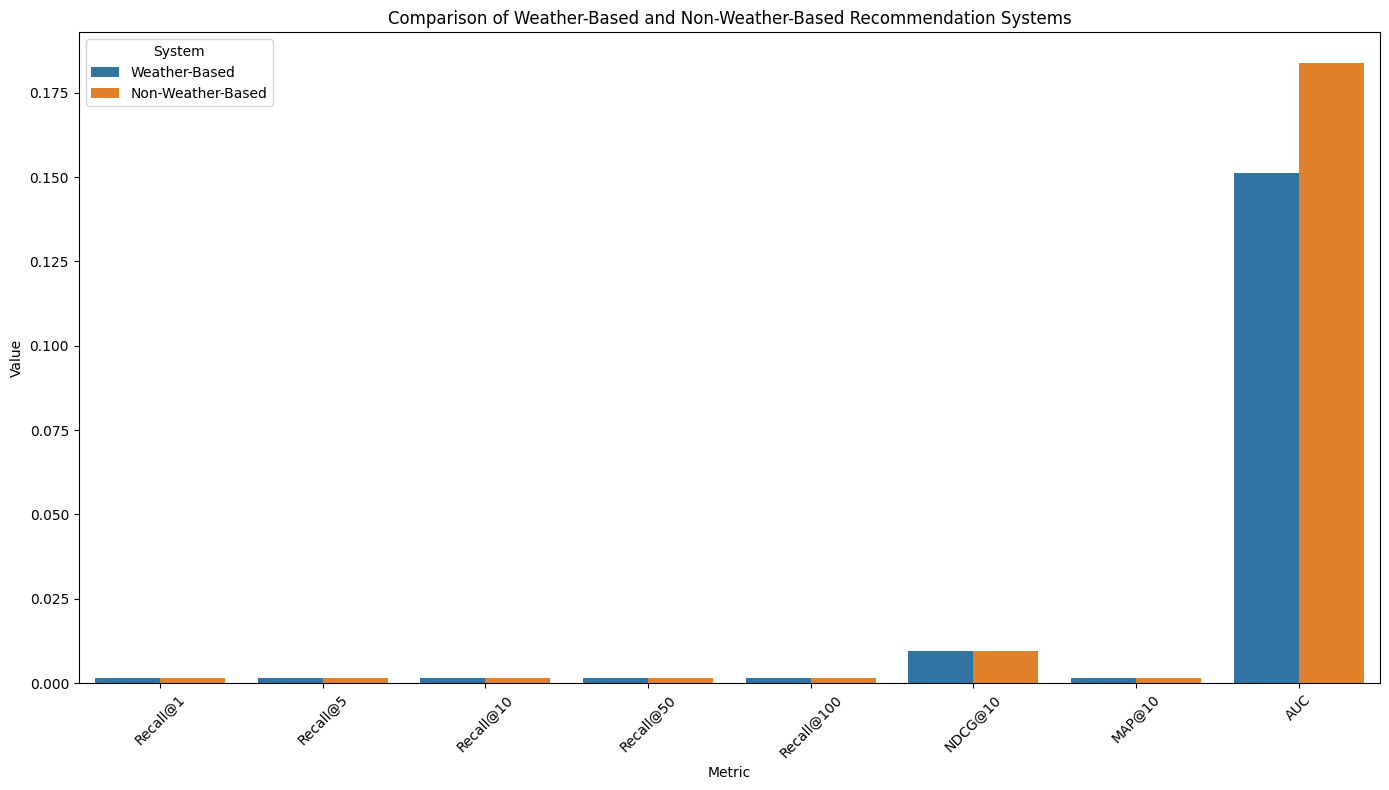

In [ ]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import faiss
from sklearn.metrics import roc_auc_score, average_precision_score
from typing import Dict, List, Tuple



# Precompute item embeddings for efficient retrieval
def precompute_item_embeddings(candidate_model, item_df):
    """Generate embeddings for all items using the candidate model"""
    item_features = {
        "event_id": item_df["event_id"].values,
        "title": item_df["title"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values
    }
    
    # Generate embeddings
    item_embeddings = candidate_model(item_features).numpy()
    return item_embeddings, item_df["event_id"].tolist()

# Build Faiss index for fast retrieval
def build_faiss_index(item_embeddings):
    """Build a Faiss index for efficient similarity search"""
    # Normalize embeddings for cosine similarity
    faiss.normalize_L2(item_embeddings)
    
    # Create index
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    
    return index

# Retrieval stage
def retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100):
    """Retrieve top-k candidates using the retrieval model"""
    # Normalize user embedding
    user_embedding_norm = user_embedding.copy()
    faiss.normalize_L2(user_embedding_norm)
    
    # Search for similar items
    distances, indices = faiss_index.search(user_embedding_norm, top_k)
    
    # Get candidate items with retrieval scores
    candidates = []
    for i, idx in enumerate(indices[0]):
        if idx < len(item_ids):
            item_id = item_ids[idx]
            score = float(distances[0][i])
            # Get full item data from events_df instead of item_df
            item_data = events_df[events_df["event_id"] == item_id]
            if not item_data.empty:
                candidates.append((item_id, score, item_data.iloc[0]))
    
    return candidates

# First, create the merged dataframe with all features
def create_merged_dataframe():
    """Create a merged dataframe containing all features from users, events, and interactions"""
    # Merge users and interactions on user_id
    print("creating merged dataframe")
    user_interactions = pd.merge(interactions_df, users_df, on='user_id', how='left')
    
    # Merge the above with events on event_id
    merged_df = pd.merge(user_interactions, events_df, on='event_id', how='left')
    
    print(f"Created merged dataframe with {len(merged_df)} rows and {len(merged_df.columns)} columns")
    
    # Force event_indoor_capability to string for CatBoost compatibility
    merged_df["event_indoor_capability"] = merged_df["event_indoor_capability"].astype(str)

    return merged_df

# Then modify the rank_candidates function to use this merged data
def create_dynamic_fallback_row(user_data, item_data, feature_names):
    """Create a fallback row dynamically matching feature_names."""
    fallback_row = {}

    for feature in feature_names:
        if feature == "user_id":
            fallback_row[feature] = user_data["user_id"]
        elif feature == "user_city":
            fallback_row[feature] = user_data.get("user_city", "unknown")
        elif feature == "user_lat":
            fallback_row[feature] = user_data.get("user_lat", 0.0)
        elif feature == "user_lon":
            fallback_row[feature] = user_data.get("user_lon", 0.0)
        elif feature == "user_weather_preference":
            fallback_row[feature] = user_data.get("user_weather_preference", "outdoor")
        elif feature == "user_interests":
            fallback_row[feature] = user_data.get("user_interests", "")

        elif feature == "event_id":
            fallback_row[feature] = item_data["event_id"]
        elif feature == "event_type":
            fallback_row[feature] = item_data["event_type"]
        elif feature == "event_city":
            fallback_row[feature] = item_data["event_city"]
        elif feature == "event_lat":
            fallback_row[feature] = item_data.get("event_lat", 0.0)
        elif feature == "event_lon":
            fallback_row[feature] = item_data.get("event_lon", 0.0)
        elif feature == "title":
            fallback_row[feature] = item_data.get("title", "")
        
        elif feature == "interaction_distance_to_event":
            fallback_row[feature] = 0.0
        elif feature == "duration":
            fallback_row[feature] = 0.0
        elif feature == "attendance_rate":
            fallback_row[feature] = 0.0
        elif feature == "event_indoor_capability":
            fallback_row[feature] = "False"
        elif feature == "weather_condition":
            fallback_row[feature] = "Clear"
        elif feature == "temperature":
            fallback_row[feature] = 20.0
        
        elif feature == "age":
            fallback_row[feature] = user_data.get("age", 30)  # Assume average age
        elif feature == "label":
            fallback_row[feature] = 0  # Always 0 for fallback
        else:
            # Unknown feature - log and set to safe default
            print(f"Warning: Unknown fallback feature {feature}, filling with 0.")
            fallback_row[feature] = 0.0

    return fallback_row


def rank_candidates(candidates, user_data, merged_df, ranking_model, weather_features=False):
    """Rank candidates using the specified ranking model and merged data."""
    if not candidates:
        return []
    
    candidate_ids = [item_id for item_id, _, _ in candidates]
    user_id = user_data['user_id']

    # Get feature names from model
    model_feature_names = ranking_model.feature_names_

    # Filter merged_df to get matching rows
    ranking_data = merged_df[
        (merged_df['user_id'] == user_id) &
        (merged_df['event_id'].isin(candidate_ids))
    ]

    # If no matches, build fallback
    if ranking_data.empty:
        temp_rows = []
        for item_id, score, item_data in candidates:
            item_data_dict = {
                "event_id": item_id,
                "event_type": item_data["event_type"],
                "event_city": item_data["event_city"],
                "title": item_data.get("title", ""),
                "event_lat": item_data.get("event_lat", 0.0),
                "event_lon": item_data.get("event_lon", 0.0)
            }
            fallback_row = create_dynamic_fallback_row(user_data, item_data_dict, model_feature_names)
            temp_rows.append(fallback_row)
        ranking_data = pd.DataFrame(temp_rows)

    # Reorder columns safely according to model
    features = ranking_data[model_feature_names].copy()

    # Create CatBoost Pool
    from catboost import Pool
    cat_features = [col for col in features.columns if features[col].dtype == 'object']
    pool = Pool(data=features, cat_features=cat_features)

    # Predict ranking scores
    ranking_scores = ranking_model.predict_proba(pool)[:, 1]

    # Map scores back
    id_to_score = {row['event_id']: score for row, score in zip(ranking_data.to_dict('records'), ranking_scores)}

    # Assemble ranked list
    ranked_items = []
    for item_id, retrieval_score, _ in candidates:
        if item_id in id_to_score:
            ranked_items.append((item_id, float(id_to_score[item_id])))
        else:
            ranked_items.append((item_id, float(retrieval_score)))

    ranked_items.sort(key=lambda x: x[1], reverse=True)
    return ranked_items



# Evaluation metrics
def recall_at_k(actual_items, recommended_items, k):
    """Calculate Recall@k"""
    if not actual_items:
        return 0.0
    
    hits = len(set(recommended_items[:k]) & set(actual_items))
    return hits / len(actual_items)

def hit_rate_at_k(actual_items, recommended_items, k):
    """Calculate Hit Rate@k"""
    if not actual_items:
        return 0.0
    
    hits = int(len(set(recommended_items[:k]) & set(actual_items)) > 0)
    return hits

def ndcg_at_k(actual_items, recommended_items, k):
    """Calculate NDCG@k"""
    if not actual_items:
        return 0.0
    
    # Create relevance list (1 if item is relevant, 0 otherwise)
    relevance = [1 if item in actual_items else 0 for item in recommended_items[:k]]
    
    # Calculate DCG
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
    
    # Calculate ideal DCG (all relevant items at the top)
    ideal_relevance = sorted([1 if item in actual_items else 0 for item in recommended_items[:k]], reverse=True)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
    
    return dcg / idcg if idcg > 0 else 0.0

def map_at_k(actual_items, recommended_items, k):
    """Calculate MAP@k"""
    if not actual_items:
        return 0.0
    
    # Calculate precision at each relevant item
    precisions = []
    relevant_items_count = 0
    
    for i, item in enumerate(recommended_items[:k]):
        if item in actual_items:
            relevant_items_count += 1
            precisions.append(relevant_items_count / (i + 1))
    
    return sum(precisions) / len(actual_items) if precisions else 0.0

def calculate_auc(all_scores, all_labels):
    """Calculate AUC"""
    if len(set(all_labels)) < 2:
        return 0.0
    return roc_auc_score(all_labels, all_scores)

# Full evaluation pipeline
# Full evaluation pipeline
def evaluate_recsys(query_model, candidate_model, weather_ranking_model, no_weather_ranking_model, test_df, k_values=[1, 5, 10, 50, 100]):
    """Evaluate both recommendation systems on multiple metrics."""
    print("Starting evaluation pipeline...")

    # Merge users, events, interactions
    merged_df = create_merged_dataframe()

    # Don't convert event_indoor_capability to string - keep original type
    # merged_df["event_indoor_capability"] = merged_df["event_indoor_capability"].astype(str)

    # Prepare item data
    item_df = events_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    print(f"Found {len(item_df)} unique items for evaluation")

    # Precompute item embeddings
    print("Precomputing item embeddings...")
    item_embeddings, item_ids = precompute_item_embeddings(candidate_model, item_df)

    # Build Faiss index
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings.copy())

    # Initialize metrics
    weather_metrics = {k: [] for k in k_values}
    weather_metrics.update({'NDCG': [], 'MAP': [], 'AUC_scores': [], 'AUC_labels': []})

    no_weather_metrics = {k: [] for k in k_values}
    no_weather_metrics.update({'NDCG': [], 'MAP': [], 'AUC_scores': [], 'AUC_labels': []})

    # Group test data by user
    user_groups = test_df.groupby("user_id")

    print(f"Evaluating {len(user_groups)} users...")
    for i, (user_id, group) in enumerate(user_groups):
        if i % 200 == 0:
            print(f"Processing user {i}/{len(user_groups)}...")

        # Lookup user
        user_filtered = users_df[users_df["user_id"] == user_id]
        if user_filtered.empty:
            print(f"Warning: User {user_id} not found in users_df, skipping...")
            continue
        user_data = user_filtered.iloc[0]

        actual_items = group["event_id"].tolist()

        # Generate user embedding
        user_features = {
            "user_id": np.array([user_data["user_id"]]),
            "user_city": np.array([user_data["user_city"]]),
            "age": np.array([user_data["age"]], dtype=np.float32),
            "user_interests": np.array([user_data["user_interests"]])
        }
        user_embedding = query_model(user_features).numpy()

        # Retrieve candidates
        candidates = retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100)

        # Rank with weather model
        weather_ranked_items = rank_candidates(candidates, user_data, merged_df, weather_ranking_model, weather_features=True)
        weather_recommended_ids = [item_id for item_id, _ in weather_ranked_items]

        # Rank with no-weather model
        no_weather_ranked_items = rank_candidates(candidates, user_data, merged_df, no_weather_ranking_model, weather_features=False)
        no_weather_recommended_ids = [item_id for item_id, _ in no_weather_ranked_items]

        # Calculate metrics
        for k in k_values:
            weather_metrics[k].append(recall_at_k(actual_items, weather_recommended_ids, k))
            no_weather_metrics[k].append(recall_at_k(actual_items, no_weather_recommended_ids, k))

        weather_metrics['NDCG'].append(ndcg_at_k(actual_items, weather_recommended_ids, 10))
        weather_metrics['MAP'].append(map_at_k(actual_items, weather_recommended_ids, 10))

        no_weather_metrics['NDCG'].append(ndcg_at_k(actual_items, no_weather_recommended_ids, 10))
        no_weather_metrics['MAP'].append(map_at_k(actual_items, no_weather_recommended_ids, 10))

        for item_id, score in weather_ranked_items:
            weather_metrics['AUC_scores'].append(score)
            weather_metrics['AUC_labels'].append(1 if item_id in actual_items else 0)

        for item_id, score in no_weather_ranked_items:
            no_weather_metrics['AUC_scores'].append(score)
            no_weather_metrics['AUC_labels'].append(1 if item_id in actual_items else 0)

    # Aggregate results
    weather_results = {}
    no_weather_results = {}

    for k in k_values:
        weather_results[f'Recall@{k}'] = np.mean(weather_metrics[k])
        no_weather_results[f'Recall@{k}'] = np.mean(no_weather_metrics[k])

    weather_results['NDCG@10'] = np.mean(weather_metrics['NDCG'])
    weather_results['MAP@10'] = np.mean(weather_metrics['MAP'])
    weather_results['AUC'] = calculate_auc(weather_metrics['AUC_scores'], weather_metrics['AUC_labels'])

    no_weather_results['NDCG@10'] = np.mean(no_weather_metrics['NDCG'])
    no_weather_results['MAP@10'] = np.mean(no_weather_metrics['MAP'])
    no_weather_results['AUC'] = calculate_auc(no_weather_metrics['AUC_scores'], no_weather_metrics['AUC_labels'])

    # Print results
    print("\n=== Evaluation Results ===")
    print("\nWeather-Based Recommendation System:")
    for metric, value in weather_results.items():
        print(f"{metric}: {value:.4f}")

    print("\nNon-Weather-Based Recommendation System:")
    for metric, value in no_weather_results.items():
        print(f"{metric}: {value:.4f}")

    # Plot
    plot_comparison(weather_results, no_weather_results)

    return weather_results, no_weather_results




def plot_comparison(weather_results, no_weather_results):
    """Plot comparison of weather-based and non-weather-based systems"""
    # Prepare data for plotting
    metrics = []
    weather_values = []
    no_weather_values = []
    
    for metric in weather_results.keys():
        metrics.append(metric)
        weather_values.append(weather_results[metric])
        no_weather_values.append(no_weather_results[metric])
    
    # Create DataFrame
    df = pd.DataFrame({
        'Metric': metrics,
        'Weather-Based': weather_values,
        'Non-Weather-Based': no_weather_values
    })
    
    # Melt DataFrame for easier plotting
    df_melted = df.melt(id_vars='Metric', var_name='System', value_name='Value')
    
    # Create plot
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Metric', y='Value', hue='System', data=df_melted)
    plt.title('Comparison of Weather-Based and Non-Weather-Based Recommendation Systems')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot
    plt.savefig('recsys_comparison.png')
    plt.show()

# Execute the evaluation pipeline
weather_results, no_weather_results = evaluate_recsys(
    query_model, 
    candidate_model, 
    weather_ranking_model, 
    no_weather_ranking_model, 
    train_df
)


In [120]:
test_df.head()

,interaction_id,user_id,user_city,age,user_interests,event_id,title,event_type,event_city
1,BI623H,UP287J,Mumbai,56,tech food travel,IO571I,balanced interactive artificial intelligence t...,Technology,Mumbai
9,e7eb7f68-8f0e-4fff-a578-f05667faf124,MD086Q,São Paulo,33,cinema literature,KH489A,functionbased bandwidthmonitored datawarehouse...,Food & Drink,London
50,68e2eefd-b9b0-4b58-85bc-fdf18b2913e0,MJ754M,Mumbai,48,fitness tech travel,IE575G,configurable attitudeoriented implementation c...,Community & Causes,Tokyo
116,d8c931ff-f2c9-4b3f-bf81-579b4c319eeb,BQ890R,Toronto,42,literature travel sports,OJ131Z,profitfocused hybrid standardization immersive...,Immersive Experiences,London
214,5ba40a45-d117-4d92-8c97-a70bf5dd4789,KF300W,New York,25,cinema art,VA099I,customizable background flexibility education ...,Education & Learning,São Paulo


Starting evaluation pipeline...
creating merged dataframe
Created merged dataframe with 165788 rows and 26 columns
Found 19989 unique items for evaluation
Building Faiss index...
Evaluating 1596 users...
Processing user 0/1596...
Processing user 200/1596...
Processing user 400/1596...
Processing user 600/1596...
Processing user 800/1596...
Processing user 1000/1596...
Processing user 1200/1596...
Processing user 1400/1596...

=== Evaluation Results ===

Weather-Based Recommendation System:
Recall@1: 0.0000
Recall@5: 0.0003
Recall@10: 0.0009
Recall@50: 0.0026
Recall@100: 0.0044
NDCG@10: 0.4050
MAP@10: 0.0005
AUC: 0.5316

Non-Weather-Based Recommendation System:
Recall@1: 0.0000
Recall@5: 0.0002
Recall@10: 0.0005
Recall@50: 0.0025
Recall@100: 0.0044
NDCG@10: 0.3014
MAP@10: 0.0002
AUC: 0.5354


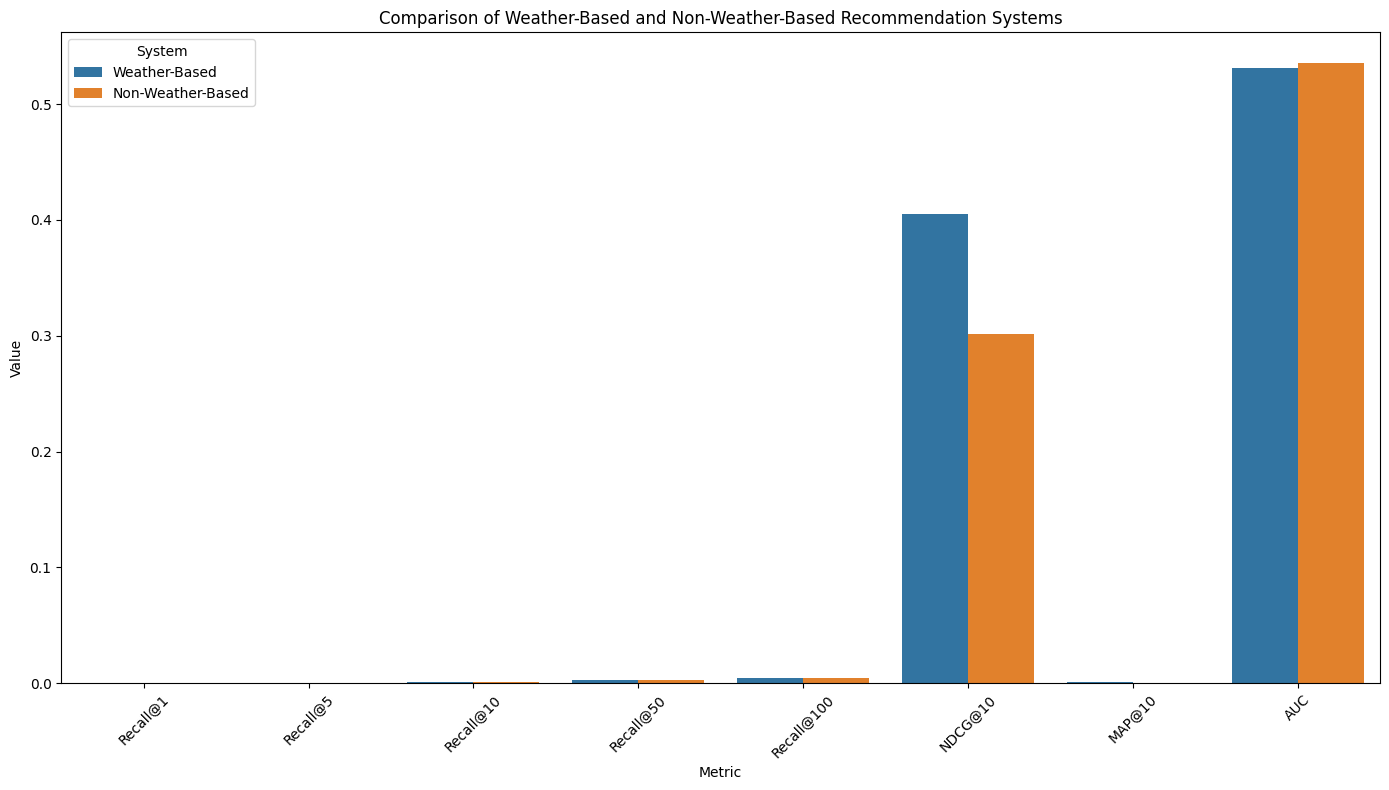

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
from sklearn.metrics import roc_auc_score

# --- Helper: Parse user interests into a set ---
def get_user_interest_set(user_interests_str):
    # Assumes user_interests is a space-separated string
    return set(map(str.lower, str(user_interests_str).split()))

# --- Precompute item embeddings for efficient retrieval ---
def precompute_item_embeddings(candidate_model, item_df):
    item_features = {
        "event_id": item_df["event_id"].values,
        "title": item_df["title"].values,
        "event_type": item_df["event_type"].values,
        "event_city": item_df["event_city"].values
    }
    item_embeddings = candidate_model(item_features).numpy()
    return item_embeddings, item_df["event_id"].tolist()

# --- Build Faiss index for fast retrieval ---
def build_faiss_index(item_embeddings):
    faiss.normalize_L2(item_embeddings)
    index = faiss.IndexFlatIP(item_embeddings.shape[1])
    index.add(item_embeddings)
    return index

# --- Retrieve top-k candidates using the retrieval model ---
def retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=1000):
    user_embedding_norm = user_embedding.copy()
    faiss.normalize_L2(user_embedding_norm)
    distances, indices = faiss_index.search(user_embedding_norm, top_k)
    candidates = []
    for i, idx in enumerate(indices[0]):
        if idx < len(item_ids):
            item_id = item_ids[idx]
            score = float(distances[0][i])
            item_data = item_df[item_df["event_id"] == item_id]
            if not item_data.empty:
                candidates.append((item_id, score, item_data.iloc[0]))
    return candidates

# --- Create merged dataframe containing all features ---
def create_merged_dataframe():
    print("creating merged dataframe")
    user_interactions = pd.merge(interactions_df, users_df, on='user_id', how='left')
    merged_df = pd.merge(user_interactions, events_df, on='event_id', how='left')
    print(f"Created merged dataframe with {len(merged_df)} rows and {len(merged_df.columns)} columns")
    merged_df["event_indoor_capability"] = merged_df["event_indoor_capability"].astype(str)
    return merged_df

# --- Fallback row builder for ranking model ---
def create_dynamic_fallback_row(user_data, item_data, feature_names):
    fallback_row = {}
    for feature in feature_names:
        if feature == "user_id":
            fallback_row[feature] = user_data["user_id"]
        elif feature == "user_city":
            fallback_row[feature] = user_data.get("user_city", "unknown")
        elif feature == "user_lat":
            fallback_row[feature] = user_data.get("user_lat", 0.0)
        elif feature == "user_lon":
            fallback_row[feature] = user_data.get("user_lon", 0.0)
        elif feature == "user_weather_preference":
            fallback_row[feature] = user_data.get("user_weather_preference", "outdoor")
        elif feature == "user_interests":
            fallback_row[feature] = user_data.get("user_interests", "")
        elif feature == "event_id":
            fallback_row[feature] = item_data["event_id"]
        elif feature == "event_type":
            fallback_row[feature] = item_data["event_type"]
        elif feature == "event_city":
            fallback_row[feature] = item_data["event_city"]
        elif feature == "event_lat":
            fallback_row[feature] = item_data.get("event_lat", 0.0)
        elif feature == "event_lon":
            fallback_row[feature] = item_data.get("event_lon", 0.0)
        elif feature == "title":
            fallback_row[feature] = item_data.get("title", "")
        elif feature == "interaction_distance_to_event":
            fallback_row[feature] = 0.0
        elif feature == "duration":
            fallback_row[feature] = 0.0
        elif feature == "attendance_rate":
            fallback_row[feature] = 0.0
        elif feature == "event_indoor_capability":
            fallback_row[feature] = "False"
        elif feature == "weather_condition":
            fallback_row[feature] = "Clear"
        elif feature == "temperature":
            fallback_row[feature] = 20.0
        elif feature == "age":
            fallback_row[feature] = user_data.get("age", 30)
        elif feature == "label":
            fallback_row[feature] = 0
        else:
            fallback_row[feature] = 0.0
    return fallback_row

# --- Rank candidates using the specified ranking model and merged data ---
def rank_candidates(candidates, user_data, merged_df, ranking_model, weather_features=False):
    if not candidates:
        return []
    candidate_ids = [item_id for item_id, _, _ in candidates]
    user_id = user_data['user_id']
    model_feature_names = ranking_model.feature_names_
    ranking_data = merged_df[
        (merged_df['user_id'] == user_id) &
        (merged_df['event_id'].isin(candidate_ids))
    ]
    if ranking_data.empty:
        temp_rows = []
        for item_id, score, item_data in candidates:
            item_data_dict = {
                "event_id": item_id,
                "event_type": item_data["event_type"],
                "event_city": item_data["event_city"],
                "title": item_data.get("title", ""),
                "event_lat": item_data.get("event_lat", 0.0),
                "event_lon": item_data.get("event_lon", 0.0)
            }
            fallback_row = create_dynamic_fallback_row(user_data, item_data_dict, model_feature_names)
            temp_rows.append(fallback_row)
        ranking_data = pd.DataFrame(temp_rows)
    features = ranking_data[model_feature_names].copy()
    from catboost import Pool
    cat_features = [col for col in features.columns if features[col].dtype == 'object']
    pool = Pool(data=features, cat_features=cat_features)
    ranking_scores = ranking_model.predict_proba(pool)[:, 1]
    id_to_score = {row['event_id']: score for row, score in zip(ranking_data.to_dict('records'), ranking_scores)}
    ranked_items = []
    for item_id, retrieval_score, _ in candidates:
        if item_id in id_to_score:
            ranked_items.append((item_id, float(id_to_score[item_id])))
        else:
            ranked_items.append((item_id, float(retrieval_score)))
    ranked_items.sort(key=lambda x: x[1], reverse=True)
    return ranked_items

# --- Evaluation metrics ---
def recall_at_k(actual_items, recommended_items, k):
    if not actual_items:
        return 0.0
    hits = len(set(recommended_items[:k]) & set(actual_items))
    return hits / len(actual_items)

def ndcg_at_k(actual_items, recommended_items, k):
    if not actual_items:
        return 0.0
    relevance = [1 if item in actual_items else 0 for item in recommended_items[:k]]
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
    ideal_relevance = sorted([1 if item in actual_items else 0 for item in recommended_items[:k]], reverse=True)
    idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance))
    return dcg / idcg if idcg > 0 else 0.0

def map_at_k(actual_items, recommended_items, k):
    if not actual_items:
        return 0.0
    precisions = []
    relevant_items_count = 0
    for i, item in enumerate(recommended_items[:k]):
        if item in actual_items:
            relevant_items_count += 1
            precisions.append(relevant_items_count / (i + 1))
    return sum(precisions) / len(actual_items) if precisions else 0.0

def calculate_auc(all_scores, all_labels):
    if len(set(all_labels)) < 2:
        return 0.0
    return roc_auc_score(all_labels, all_scores)

# --- Full evaluation pipeline with interest-based relevance ---
def get_user_interest_set(user_interests_str):
    # Assumes user_interests is a space-separated string
    return set(map(str.lower, str(user_interests_str).split()))

def evaluate_recsys(query_model, candidate_model, weather_ranking_model, no_weather_ranking_model, test_df, k_values=[1, 5, 10, 50, 100]):
    print("Starting evaluation pipeline...")

    merged_df = create_merged_dataframe()
    item_df = events_df[CANDIDATE_FEATURES].drop_duplicates(subset="event_id").dropna()
    print(f"Found {len(item_df)} unique items for evaluation")

    item_embeddings, item_ids = precompute_item_embeddings(candidate_model, item_df)
    print("Building Faiss index...")
    faiss_index = build_faiss_index(item_embeddings.copy())

    weather_metrics = {k: [] for k in k_values}
    weather_metrics.update({'NDCG': [], 'MAP': [], 'AUC_scores': [], 'AUC_labels': []})

    no_weather_metrics = {k: [] for k in k_values}
    no_weather_metrics.update({'NDCG': [], 'MAP': [], 'AUC_scores': [], 'AUC_labels': []})

    user_groups = test_df.groupby("user_id")
    print(f"Evaluating {len(user_groups)} users...")
    for i, (user_id, group) in enumerate(user_groups):
        if i % 200 == 0:
            print(f"Processing user {i}/{len(user_groups)}...")

        user_filtered = users_df[users_df["user_id"] == user_id]
        if user_filtered.empty:
            print(f"Warning: User {user_id} not found in users_df, skipping...")
            continue
        user_data = user_filtered.iloc[0]

        # --- Interest-based relevance: events whose event_type matches any user interest ---
        user_interest_set = get_user_interest_set(user_data["user_interests"])
        relevant_events = set()
        for _, event_row in events_df.iterrows():
            event_type = str(event_row["event_type"]).lower()
            if any(interest in event_type for interest in user_interest_set):
                relevant_events.add(event_row["event_id"])

        user_features = {
            "user_id": np.array([user_data["user_id"]]),
            "user_city": np.array([user_data["user_city"]]),
            "age": np.array([user_data["age"]], dtype=np.float32),
            "user_interests": np.array([user_data["user_interests"]])
        }
        user_embedding = query_model(user_features).numpy()
        candidates = retrieve_candidates(user_embedding, faiss_index, item_ids, item_df, top_k=100)

        weather_ranked_items = rank_candidates(candidates, user_data, merged_df, weather_ranking_model, weather_features=True)
        weather_recommended_ids = [item_id for item_id, _ in weather_ranked_items]

        no_weather_ranked_items = rank_candidates(candidates, user_data, merged_df, no_weather_ranking_model, weather_features=False)
        no_weather_recommended_ids = [item_id for item_id, _ in no_weather_ranked_items]

        for k in k_values:
            weather_metrics[k].append(recall_at_k(relevant_events, weather_recommended_ids, k))
            no_weather_metrics[k].append(recall_at_k(relevant_events, no_weather_recommended_ids, k))

        weather_metrics['NDCG'].append(ndcg_at_k(relevant_events, weather_recommended_ids, 10))
        weather_metrics['MAP'].append(map_at_k(relevant_events, weather_recommended_ids, 10))

        no_weather_metrics['NDCG'].append(ndcg_at_k(relevant_events, no_weather_recommended_ids, 10))
        no_weather_metrics['MAP'].append(map_at_k(relevant_events, no_weather_recommended_ids, 10))

        for item_id, score in weather_ranked_items:
            weather_metrics['AUC_scores'].append(score)
            weather_metrics['AUC_labels'].append(1 if item_id in relevant_events else 0)

        for item_id, score in no_weather_ranked_items:
            no_weather_metrics['AUC_scores'].append(score)
            no_weather_metrics['AUC_labels'].append(1 if item_id in relevant_events else 0)

    weather_results = {}
    no_weather_results = {}
    for k in k_values:
        weather_results[f'Recall@{k}'] = np.mean(weather_metrics[k])
        no_weather_results[f'Recall@{k}'] = np.mean(no_weather_metrics[k])

    weather_results['NDCG@10'] = np.mean(weather_metrics['NDCG'])
    weather_results['MAP@10'] = np.mean(weather_metrics['MAP'])
    weather_results['AUC'] = calculate_auc(weather_metrics['AUC_scores'], weather_metrics['AUC_labels'])

    no_weather_results['NDCG@10'] = np.mean(no_weather_metrics['NDCG'])
    no_weather_results['MAP@10'] = np.mean(no_weather_metrics['MAP'])
    no_weather_results['AUC'] = calculate_auc(no_weather_metrics['AUC_scores'], no_weather_metrics['AUC_labels'])

    print("\n=== Evaluation Results ===")
    print("\nWeather-Based Recommendation System:")
    for metric, value in weather_results.items():
        print(f"{metric}: {value:.4f}")

    print("\nNon-Weather-Based Recommendation System:")
    for metric, value in no_weather_results.items():
        print(f"{metric}: {value:.4f}")

    plot_comparison(weather_results, no_weather_results)
    return weather_results, no_weather_results


def plot_comparison(weather_results, no_weather_results):
    metrics = []
    weather_values = []
    no_weather_values = []
    for metric in weather_results.keys():
        metrics.append(metric)
        weather_values.append(weather_results[metric])
        no_weather_values.append(no_weather_results[metric])
    df = pd.DataFrame({
        'Metric': metrics,
        'Weather-Based': weather_values,
        'Non-Weather-Based': no_weather_values
    })
    df_melted = df.melt(id_vars='Metric', var_name='System', value_name='Value')
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Metric', y='Value', hue='System', data=df_melted)
    plt.title('Comparison of Weather-Based and Non-Weather-Based Recommendation Systems')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('recsys_comparison.png')
    plt.show()

# To run:
weather_results, no_weather_results = evaluate_recsys(
    query_model, candidate_model, weather_ranking_model, no_weather_ranking_model, test_df
)
